# Taxi Data

- look at countries - stacked/grouped bar chart? bar for the whole contry split by where rides were taken
- look at dates/months - line chart? with a month cumulative bar in the back ground for numbers of rides taken

In [35]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### variables

In [18]:
currency_values = {
    'COP': 2800,
    'USD': 0.7,
    'PEN': 2.7,
    'BOB': 5,
    'BRL': 4,
    'GTQ': 5.2,
    'MK': 1240,
    'MT': 46
}

#### functions

In [13]:
# formatting columns to be nicer to work with
def format_names(df):
    for col in df.columns:
        df = df.rename(columns={col: col.replace(' ','_')})

    return df

In [14]:
taxi = pd.read_csv('../data/taxi_data.csv')
taxi = format_names(taxi).rename(columns={'Unnamed:_1':'date','duration_(min)':'duration_min'})
taxi['date'] = pd.to_datetime(taxi['date'], format='%m/%d/%Y')

taxi.head()

,type,date,city,country,duration_min,price,dollar,payment_type,app
0,moto,2024-03-21,Medellín,Columbia,7,5240.0,COP,card,Uber
1,moto,2024-03-21,Medellín,Columbia,8,5240.0,COP,card,Uber
2,moto,2024-04-02,Bogotá,Columbia,15,5020.0,COP,card,Uber
3,moto,2024-04-02,Bogotá,Columbia,17,11350.0,COP,card,Uber
4,car,2024-04-05,Bogotá,Columbia,50,24970.0,COP,card,Uber


In [23]:
# getting all the prices of taxis in canadian dollar so everything is comparable
for idx, row in taxi.iterrows():
    taxi.loc[idx, 'cad_price'] = np.round(row.price / currency_values[row.dollar],2)

In [24]:
taxi.head()

,type,date,city,country,duration_min,price,dollar,payment_type,app,cad_price
0,moto,2024-03-21,Medellín,Columbia,7,5240.0,COP,card,Uber,1.87
1,moto,2024-03-21,Medellín,Columbia,8,5240.0,COP,card,Uber,1.87
2,moto,2024-04-02,Bogotá,Columbia,15,5020.0,COP,card,Uber,1.79
3,moto,2024-04-02,Bogotá,Columbia,17,11350.0,COP,card,Uber,4.05
4,car,2024-04-05,Bogotá,Columbia,50,24970.0,COP,card,Uber,8.92


In [62]:
# total amounts
t_overall = taxi.groupby('type').agg({
    'cad_price': 'sum',
    'date': 'count',
    'duration_min': 'sum'
}).reset_index().rename(columns={'date':'num_of_times'})

t_overall['duration_hr'] = np.round(t_overall.duration_min / 60, 2)

t_overall

,type,cad_price,num_of_times,duration_min,duration_hr
0,car,197.38,49,655,10.92
1,moto,300.13,117,1541,25.68
2,quad,15.00,2,40,0.67
3,tuktuk,4.22,2,13,0.22


### how did i get the taxis?
- mostly through the main apps of uber and 99 (in brasil)

In [59]:
uber = taxi.groupby('app').date.count().reset_index().rename(columns={'date':'num_of_times'})
uber

,app,num_of_times
0,99,67
1,Uber,74
2,inDrive,19
3,street,9
4,yango,1


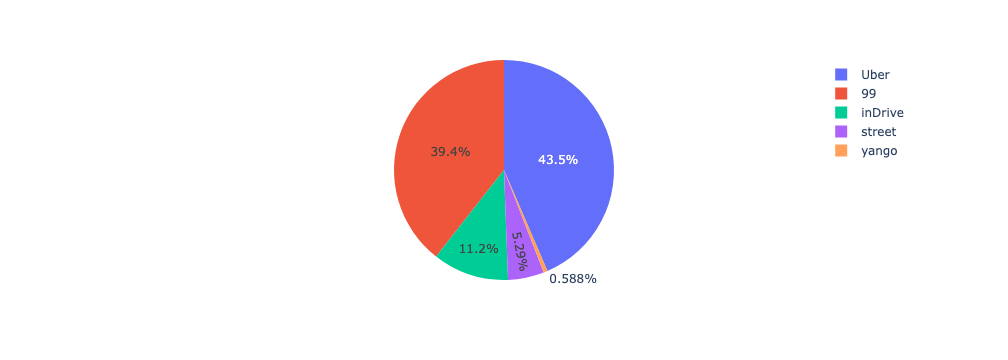

In [61]:
fig = px.pie(uber, values='num_of_times', names='app')
fig.show()

### looking by country

In [39]:
t_countries = taxi.groupby(['country','type']).agg({
    'cad_price': 'sum',
    'date': 'count',
    'duration_min': 'sum'
}).reset_index().rename(columns={'date':'num'})

t_countries

,country,type,cad_price,num,duration_min
0,Bolivia,car,44.80,15,148
1,Bolivia,tuktuk,2.00,1,7
2,Brasil,car,124.33,27,409
3,Brasil,moto,247.76,101,1248
4,Brasil,quad,15.00,2,40
5,Columbia,car,12.97,2,54
6,Columbia,moto,9.58,4,47
7,Ecuador,car,2.06,1,3
8,El Salvador,moto,6.58,2,24
9,Guatemala,moto,6.83,2,26


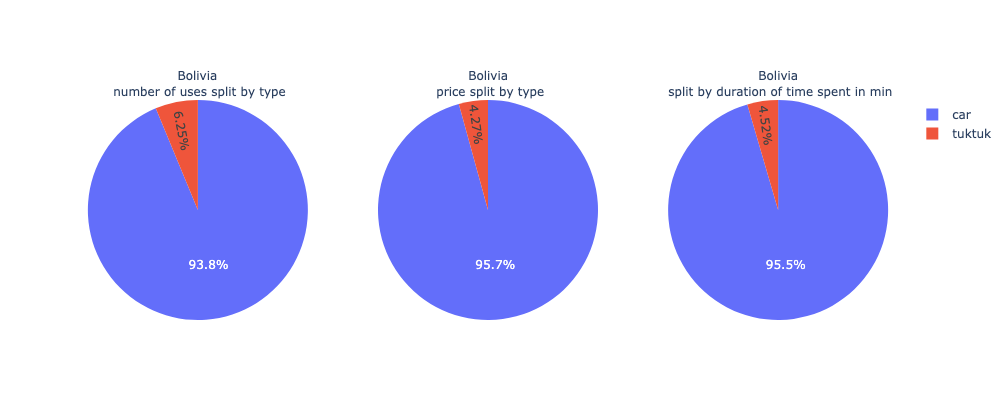

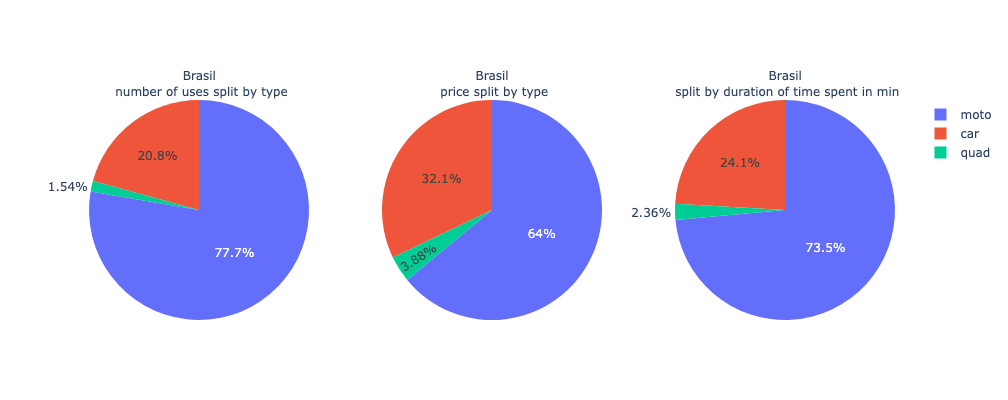

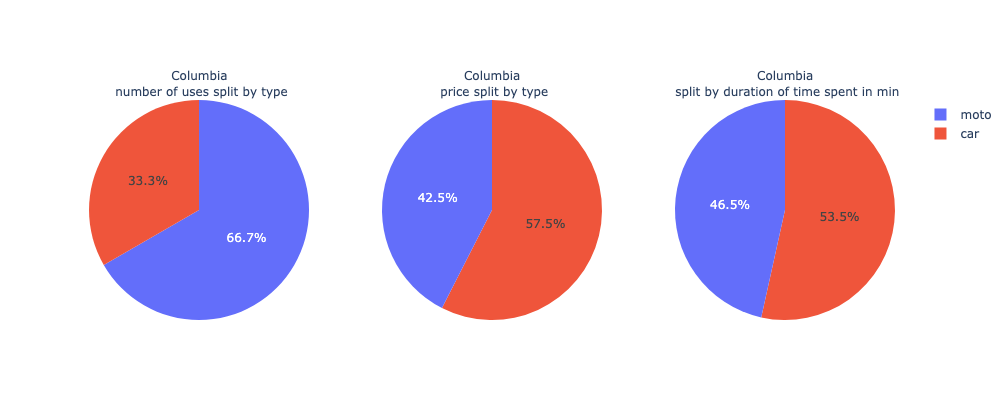

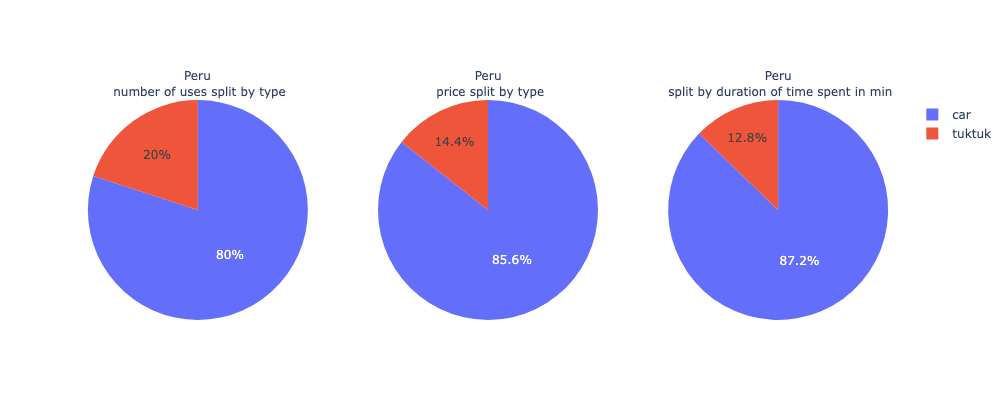

countries where only one type of taxi was used: ['Ecuador', 'El Salvador', 'Guatemala', 'Malawi', 'Mozambique']


In [54]:
not_split_list = []
for c in t_countries.country.unique():
    clip = t_countries[t_countries.country == c]

    # if theres only one type of taxi
    if clip.shape[0] == 1:
        not_split_list.append(c)

    else:
        fig = make_subplots(
            rows=1, 
            cols=3, 
            specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
            subplot_titles=(
                '{}<br> number of uses split by type'.format(c), 
                '{}<br> price split by type'.format(c),
                '{}<br> split by duration of time spent in min'.format(c)
            )
        )
    
        fig.add_trace(
            go.Pie(labels=clip.type, values=clip.num),
            row=1, col=1
        )
    
        fig.add_trace(
            go.Pie(labels=clip.type, values=clip.cad_price),
            row=1, col=2
        )

        fig.add_trace(
            go.Pie(labels=clip.type, values=clip.duration_min),
            row=1, col=3
        )

        for ann in fig.layout.annotations:
            ann.font.size = 12 
    
        fig.update_layout(
            # title_text="Two Pie Charts Side by Side",
            width=800,
            height=400
        )
        
        fig.show()

# print the list of countries that only have one set of taxis
print ('countries where only one type of taxi was used: {}'.format(not_split_list))

In [67]:
t_avg = taxi.groupby(['country']).agg({
    'cad_price': 'mean',
    'duration_min': 'mean'
}).reset_index().rename(columns={'date':'num'})

t_avg

,country,cad_price,duration_min
0,Bolivia,2.925000,9.687500
1,Brasil,2.977615,13.053846
2,Columbia,3.758333,16.833333
3,Ecuador,2.060000,3.000000
4,El Salvador,3.290000,12.000000
5,Guatemala,3.415000,13.000000
6,Malawi,3.917143,26.285714
7,Mozambique,1.960000,12.000000
8,Peru,3.088000,9.400000


#### brasilian break down
- lets be honest... this is the only time the taxis were exciting

In [63]:
t_countries[t_countries.country == 'Brasil']

,country,type,cad_price,num,duration_min
2,Brasil,car,124.33,27,409
3,Brasil,moto,247.76,101,1248
4,Brasil,quad,15.00,2,40


In [81]:
brasil = taxi[taxi.country == 'Brasil']
brasil

,type,date,city,country,duration_min,price,dollar,payment_type,app,cad_price
28,moto,2024-08-20,Campo Grande,Brasil,15,11.10,BRL,cash,Uber,2.78
29,moto,2024-08-21,Campo Grande,Brasil,8,7.11,BRL,cash,Uber,1.78
30,moto,2024-08-21,Campo Grande,Brasil,7,7.17,BRL,cash,Uber,1.79
31,moto,2024-08-21,Campo Grande,Brasil,18,18.94,BRL,cash,Uber,4.74
32,car,2024-08-22,Brasília,Brasil,19,26.93,BRL,cash,Uber,6.73
...,...,...,...,...,...,...,...,...,...,...
153,moto,2024-12-17,Rio de Janeiro,Brasil,25,12.00,BRL,cash,99,3.00
154,moto,2024-12-17,Rio de Janeiro,Brasil,13,7.00,BRL,cash,99,1.75
155,moto,2024-12-18,Rio de Janeiro,Brasil,9,11.35,BRL,card,Uber,2.84
156,moto,2024-12-18,Rio de Janeiro,Brasil,18,12.00,BRL,cash,99,3.00


In [106]:
# most efficient ride
brasil.loc[:,'rate'] = brasil.cad_price / brasil.duration_min
brasil.loc[brasil.rate.idxmin()]

type                           moto
date            2024-09-03 00:00:00
city                          Belém
country                      Brasil
duration_min                     11
price                           2.4
dollar                          BRL
payment_type                   cash
app                              99
cad_price                       0.6
rate                       0.054545
month                September 2024
Name: 50, dtype: object

In [111]:
brasil.loc[:,'month'] = brasil['date'].dt.strftime("%B %Y")
b_grp = brasil.groupby(['month','type']).city.count().reset_index().rename(columns={'city':'num'})
b_grp.loc[:,'month_num'] = pd.to_datetime(b_grp['month'], format="%B %Y")
b_grp = b_grp.sort_values('month_num', ascending=True)

b_grp

,month,type,num,month_num
0,August 2024,car,9,2024-08-01
1,August 2024,moto,10,2024-08-01
9,September 2024,car,2,2024-09-01
10,September 2024,moto,23,2024-09-01
6,October 2024,car,2,2024-10-01
7,October 2024,moto,8,2024-10-01
8,October 2024,quad,2,2024-10-01
4,November 2024,car,9,2024-11-01
5,November 2024,moto,37,2024-11-01
2,December 2024,car,5,2024-12-01


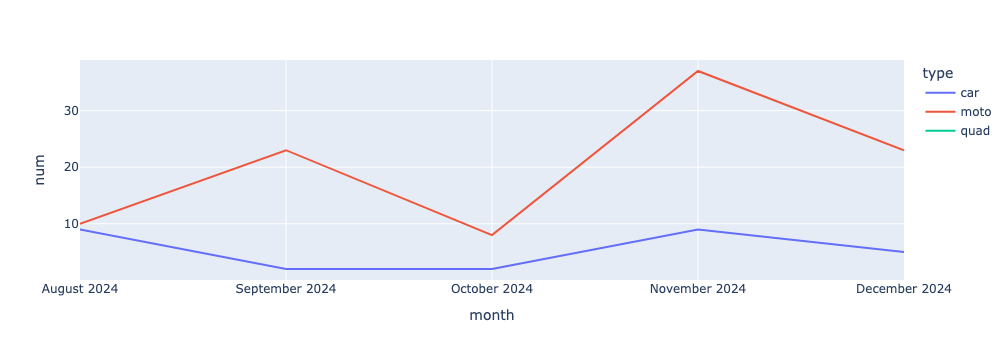

In [112]:
fig = px.line(b_grp, x='month', y='num', color='type')
fig.show()

#### max number of taxis i took in a day -- in Recife!
- i remeber this day... i only had one full day in the city. i went and saw the sights and went to visit Diego for lunch

In [110]:
max_times = brasil.groupby(['date','type']).city.count().reset_index().rename(columns={'city':'num'})
mt = max_times.loc[max_times.num.idxmax()]
mt

date    2024-09-24 00:00:00
type                   moto
num                       8
Name: 20, dtype: object

In [103]:
max_day = brasil[brasil.date == mt.date]
print ('it cost me a total of: ${}'.format(max_day.cad_price.sum()))
max_day

it cost me a total of: $14.29


,type,date,city,country,duration_min,price,dollar,payment_type,app,cad_price,rate,month
63,moto,2024-09-24,Recife,Brasil,16,7.83,BRL,card,Uber,1.96,0.122500,September 2024
64,moto,2024-09-24,Recife,Brasil,14,10.14,BRL,card,Uber,2.54,0.181429,September 2024
65,moto,2024-09-24,Recife,Brasil,11,7.31,BRL,card,Uber,1.83,0.166364,September 2024
66,moto,2024-09-24,Recife,Brasil,7,5.17,BRL,card,Uber,1.29,0.184286,September 2024
67,moto,2024-09-24,Recife,Brasil,5,5.37,BRL,card,Uber,1.34,0.268000,September 2024
68,moto,2024-09-24,Recife,Brasil,17,9.78,BRL,card,Uber,2.44,0.143529,September 2024
69,moto,2024-09-24,Recife,Brasil,10,5.81,BRL,card,Uber,1.45,0.145000,September 2024
70,moto,2024-09-24,Recife,Brasil,15,5.76,BRL,cash,99,1.44,0.096000,September 2024
